In [1]:
# Read the simulated data
import pandas as pd
import numpy as np
import math
from scipy.signal import savgol_filter

def sigmoid(x):
    # sign = float(x)/abs(x) if x != 0 else 0 
    # return sign* math.log((abs(1000*x) + 1))
    return (1/(1+math.exp(-200*x)) - 0.5)

window = 10
def deviation_from_windowed_mean(ser):
    return [abs(ser.iloc[i] - ser.iloc[max(0, i - window): i].mean())
            for i in range(len(ser))]

def compute_velocity(ser):
    mn, mx = float(ser.min()), float(ser.max())
    print "Min, Max: ", mn, mx
    diff = float(mx - mn)
    a, b = 50, 127
    return [(x/mx) * (b-a) + a for x in ser]
    
        
df = pd.read_csv("../data/the_great_recession.csv")
df = df[170:700]  # Limit till 2010
# print df["DATE"].apply(lambda x: x[:4]).value_counts()
# Note ts should already be in datetime
print "Dataset size: %s rows, %s columns" % df.shape
# set 'tick' as index
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)
ts = df[df.VALUE.notnull()].copy(deep=True)
ts["value_smoothed"] = savgol_filter(ts["VALUE"].values, 51, 3) 
compute_change_on = "value_smoothed"

# ts["log_change"] = ts.VALUE.apply(sigmoid)
ts["rate_of_change"] = [(ts["VALUE"].iloc[i + 1] - ts.VALUE.iloc[i]) / float(
    ts.VALUE.iloc[i]) for i in range(len(ts) - 1)] + [np.nan]

# change 
ts = ts[ts.rate_of_change.notnull()].copy(deep=True)

# ts["deviation_from_windowed_mean"] = deviation_from_windowed_mean(ts[compute_change_on].abs())
# ts["velocity"] = compute_velocity(ts["deviation_from_windowed_mean"])

ts["rate_of_change_smoothed"] = savgol_filter(ts["rate_of_change"].abs().values, 51, 3)
ts["velocity"] = compute_velocity(ts["rate_of_change_smoothed"] )
assert ts.velocity.max() <= 127

ts.fillna(0, inplace=True)
pitch_var = "value_smoothed"


Dataset size: 530 rows, 2 columns
Min, Max:  0.00380520810261 0.0410770917283


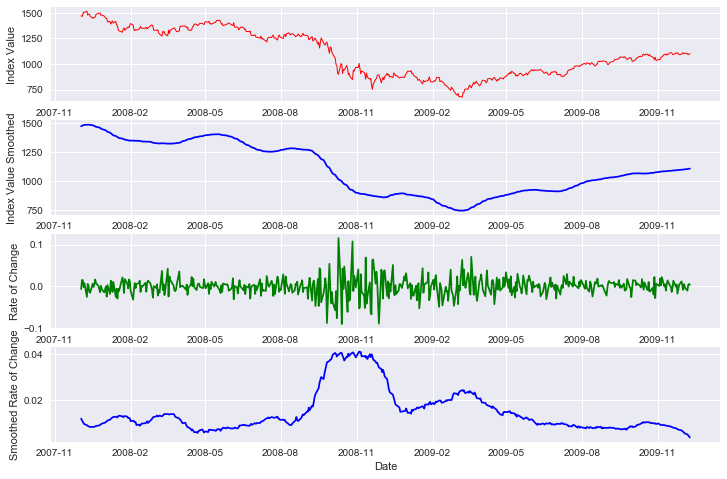

In [2]:
# plot time series and save the figure                                                                                                                                                        
%matplotlib inline
import matplotlib
import seaborn as sns
fig = sns.plt.figure(figsize=(12, 8))

sns.plt.title("The Great Recession")

sns.plt.subplot(411)
sns.plt.plot(ts["VALUE"], "-r", lw=1)
sns.plt.ylabel("Index Value")

sns.plt.subplot(412)
sns.plt.plot(ts["value_smoothed"], "-b")
sns.plt.ylabel("Index Value Smoothed")

sns.plt.subplot(413)
sns.plt.plot(ts["rate_of_change"], "-g")
sns.plt.ylabel("Rate of Change")

sns.plt.subplot(414)
sns.plt.plot(ts["rate_of_change_smoothed"], "-b")
sns.plt.ylabel("Smoothed Rate of Change")


sns.plt.xlabel("Date")
sns.plt.show()

In [3]:

from miditime.miditime import MIDITime
from datetime import timedelta, datetime

bpm = 60  # tempo in beats per minute (120bpm is the default)
out_file = '../data/great_recession.mid'  # output file destination
secs_per_year = 15  # the number of seconds you want to represent a year in the final song (default is 5 sec/year)
base_octave = 5  # the base octave (C5 is middle C, so the default is 5, 
num_octaves = 3  # how many octaves you want your output to range over (default is 1)
# Instantiate the class
midi = MIDITime(bpm, out_file, secs_per_year, base_octave, num_octaves)

ts["epoch"] = map(lambda x: midi.days_since_epoch(x), ts.index)
# Convert "days" since epoch" to number of beats since epoch. In the current config,
ts["beat"] = ts.epoch.apply(midi.beat)
start_time = ts.beat.iloc[0]
beats_per_second = bpm / 60.0
ts["song_time"] = ts["beat"].apply(lambda x: (x-start_time)/beats_per_second)


In [4]:
# Set up a functions to scale magnitude to match your desired mode/key and octave range.
def mag_to_pitch_tuned(magnitude, scale="linear", reversed=False, debug=False):
    # Where does this data point sit in the domain of your data? (I.E. the min magnitude is 3, the max in 5.6). In this case the optional 'True' means the scale is reversed, so the highest value will return the lowest percentage.
    if scale == "linear":
        scale_pct = midi.linear_scale_pct(ts[pitch_var].min(), ts[pitch_var].max(), magnitude, reversed)
    elif scale == "log":
        scale_pct = midi.log_scale_pct(ts[pitch_var].min(), ts[pitch_var].max(), magnitude, reversed)
    else:
        raise Exception("Invalid scale type '%s'" % scale)
    # Pick a range of notes. This allows you to play in a key.
    c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    d_minor = ['D', 'E', 'F', 'G', 'A', 'Bb', 'C']
    #Find the note that matches your data point
    note = midi.scale_to_note(scale_pct, d_minor)
    #Translate that note to a MIDI pitch
    midi_pitch = midi.note_to_midi_pitch(note)

    return pd.Series({"a": midi_pitch, "b": note, "c": scale_pct})
 

In [5]:
# Change the ISE values to sensible mode/key and octave range.
# remove all the zeroes before adding it to out
ts[["tuned_pitch", "note", "scale_pct"]]  = ts[pitch_var].apply(mag_to_pitch_tuned, scale="linear", reversed=False)
# Run some stats
print "Range for tuned pitch: (%d, %d)" % (ts.tuned_pitch.min(), ts.tuned_pitch.max()) 
print "\nPitch values for Peak Region (May 2010): "
print ts[[pitch_var, "song_time", "tuned_pitch", "note"]].head()
print "\nValue Counts of Notes: "
print ts.note.value_counts()
# ts.to_csv("../data/pitch.csv")
# Note - The peak happens around t = 40 seconds

Range for tuned pitch: (62, 94)

Pitch values for Peak Region (May 2010): 
            value_smoothed  song_time  tuned_pitch note
DATE                                                   
2007-12-03     1475.211858       0.00           94  Bb7
2007-12-04     1479.778899       0.04           94  Bb7
2007-12-05     1483.444308       0.08           94  Bb7
2007-12-06     1486.247173       0.12           94  Bb7
2007-12-07     1488.226581       0.16           94  Bb7

Value Counts of Notes: 
G5     71
A5     53
F7     43
G7     41
E6     38
D7     34
E7     33
F6     30
D6     26
D5     24
C7     22
F5     18
Bb7    18
C6     17
E5     14
Bb5    13
A7      6
A6      4
Bb6     4
G6      2
Name: note, dtype: int64


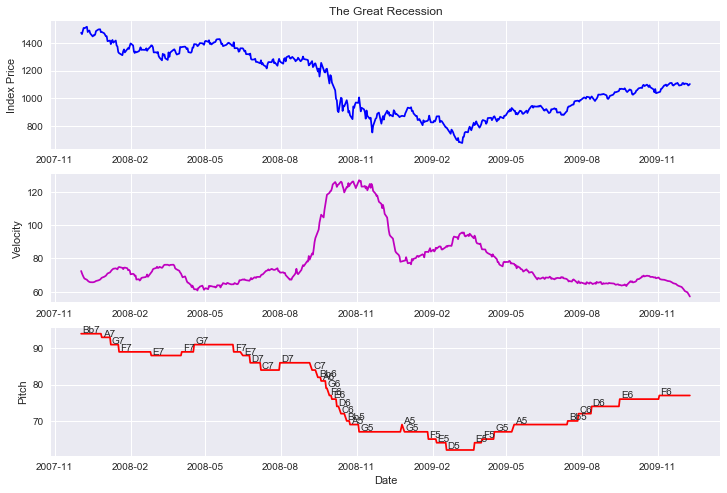

In [6]:
# Now plot timeseries with the original magnitude and the tuned pitch
# plot time series and save the figure 
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns


fig = sns.plt.figure(figsize=(12, 8))
sns.plt.subplot(311)
sns.plt.plot(ts["VALUE"], "b-")
sns.plt.ylabel("Index Price")
sns.plt.title("The Great Recession")

sns.plt.subplot(312)
sns.plt.plot(ts["velocity"], "-m")
sns.plt.ylabel("Velocity")

ax = sns.plt.subplot(313)
# sns.plt.bar(ts["tuned_pitch"].index, [ts["tuned_pitch"].iloc[i] if ts[pitch_var].iloc[i] != 0 else 0 for i in range(len(ts))])
sns.plt.plot(ts["tuned_pitch"], 'r-')
sns.plt.ylabel("Pitch")

sns.plt.xlabel("Date")

for  i in range(len(ts)):
    if ts[pitch_var].iloc[i] == 0:
        continue
    if ts["note"].iloc[i] == ts["note"].iloc[i-1]:
        continue
    ind = ts.index[i]
    ax.annotate(ts["note"].iloc[i], (ind, ts["tuned_pitch"].iloc[i]), xytext=(1, 1), textcoords='offset points',
                family='sans-serif', fontsize=10)

fig.canvas.draw()

sns.plt.show()

In [7]:
# Build the node list
note_list = []
for i in range(len(ts)):
    # No notes for zeroes
    if ts[pitch_var].iloc[i] == 0:
         continue
    if ts["note"].iloc[i] == ts["note"].iloc[i-1]:
        continue            
    note_list.append([
        ts['beat'].iloc[i] - start_time,
        ts['tuned_pitch'].iloc[i],
        ts['velocity'].iloc[i],  # velocity
        1  # duration, in beats
    ])

# Now change duration based on the difference between subsequent notes (add 0.1 to maintain some natural continuity)
for i in range(len(note_list)-1):
    note_list[i][3] = note_list[i+1][0] - note_list[i][0]
    
# Add a track with those notes
midi.add_track(note_list)

# Save the .mid file to disk. 
midi.save_midi()

# You can convert the .mid file to a .wav file by using the utility timidity
# timidity ise.mid -Ow
# timidity can be installed using apt-get


(94, 0.0, 1.0300000000000864, 72.461850243683429)
(93, 1.0300000000000864, 0.44999999999993179, 68.389740750640456)
(91, 1.4800000000000182, 0.40999999999996817, 72.28038877266107)
(89, 1.8899999999999864, 1.6000000000000227, 74.865630575450496)
(88, 3.4900000000000091, 1.5199999999999818, 71.494679013896288)
(89, 5.0099999999999909, 0.61000000000001364, 69.766475087443808)
(91, 5.6200000000000045, 1.9800000000000182, 61.477969254222117)
(89, 7.6000000000000227, 0.45000000000004547, 64.501508818870732)
(88, 8.0500000000000682, 0.37000000000000455, 67.39099441079415)
(86, 8.4200000000000728, 0.52999999999997272, 67.33380645902281)
(84, 8.9500000000000455, 0.95000000000004547, 69.865095627018974)
(86, 9.9000000000000909, 1.5999999999999091, 71.549867561654381)
(84, 11.5, 0.2800000000000864, 82.985022232825301)
(82, 11.780000000000086, 0.16999999999995907, 96.057877593377626)
(81, 11.950000000000045, 0.25, 106.29028155283343)
(79, 12.200000000000045, 0.15999999999996817, 115.1465272230893